# Notebook for Training with Faster RCNN

We'll import code from the scripts folder so we don't have to clutter this notebook

In [1]:
%matplotlib inline

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import sys
import torch
import torchvision

from albumentations import OneOf

sys.path.append(os.path.join('..', 'scripts'))
from models import WheatModel
from evaluation import calculate_image_precision

sns.set()

%load_ext autoreload
%autoreload

ALLOW_AUTOMATIC_SHUTDOWN = True # allow the script to automatically shutdown your computer after use.

C:\Users\Alan\Anaconda3\envs\wheat-detection\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Iteration #50 loss: 1.054091453552246
Iteration #100 loss: 1.0789328813552856
Iteration #150 loss: 0.7947908639907837
Iteration #200 loss: 0.7813953161239624
Iteration #250 loss: 0.6782088279724121
Iteration #300 loss: 0.8446503281593323
Iteration #350 loss: 1.0946600437164307
Iteration #400 loss: 0.6965304017066956
Iteration #450 loss: 0.6116796731948853
Iteration #500 loss: 0.9686131477355957
Iteration #550 loss: 0.6712099313735962
Iteration #600 loss: 0.7520854473114014
Iteration #650 loss: 0.9206393957138062
Iteration #700 loss: 0.8408923149108887
Iteration #750 loss: 0.6982057094573975
Iteration #800 loss: 1.0580105781555176
Epoch #0 loss: 0.9058580218827555
Wall time: 11min 21s


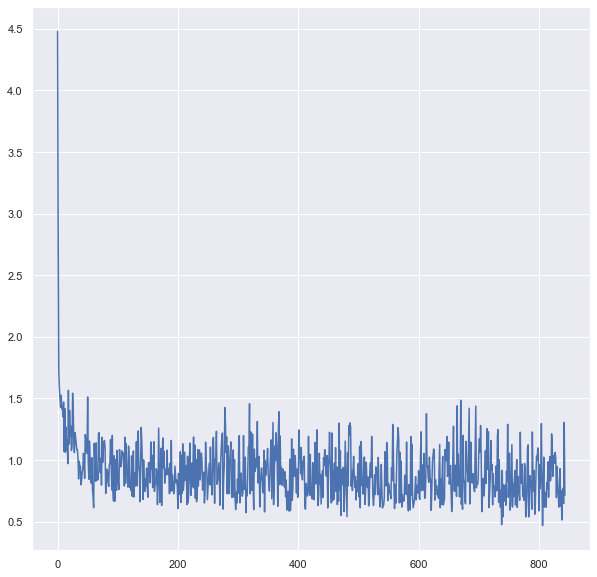

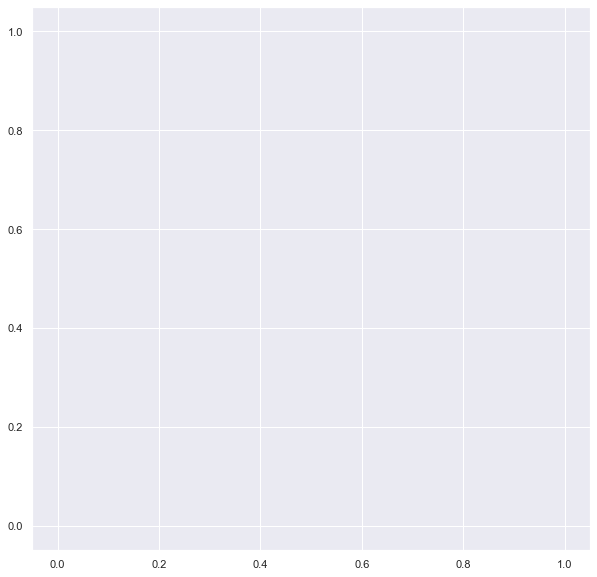

In [2]:
%%time
base_path = os.path.join('..', 'data')

model = WheatModel(
    base_path=base_path,
    num_epochs=1,
    train_val_split=1,
    transforms=[A.Flip(0.5), 
#                     A.RandomBrightnessContrast(), 
                OneOf([
                    A.RandomBrightnessContrast(), 
                    A.HueSaturationValue()
                ], p=0.5),
                OneOf([
                    A.MotionBlur()
                ])
               ]
)
loss, precisions=model.main()
plt.figure(figsize=(10, 10))
plt.plot(loss)
plt.figure(figsize=(10, 10))
plt.plot(precisions)
model.save_params()

# Validation

In [2]:
base_path = os.path.join('..', 'data')

model = WheatModel(
    base_path=base_path,
    num_epochs=1,
    train_val_split=0.8,
    weights_file='faster_rcnn_resnet50_fpn_10epochs.pth'
)

In [6]:
# Our testing sample
sample_id = '1ef16dab1'

gt_boxes = model.train_df[model.train_df['image_id'] == sample_id][['x', 'y', 'w', 'h']].values
gt_boxes = gt_boxes.astype(np.int)

# Ground-truth boxes of our sample
gt_boxes

array([[954, 391,  70,  90],
       [660, 220,  95, 102],
       [ 64, 209,  76,  57],
       [896,  99, 102,  69],
       [747, 460,  72,  77],
       [885, 163, 103,  69],
       [514, 399,  90,  97],
       [702, 794,  97,  99],
       [721, 624,  98, 108],
       [826, 512,  82,  94],
       [883, 944,  79,  74],
       [247, 594, 123,  92],
       [673, 514,  95, 113],
       [829, 847, 102, 110],
       [ 94, 737,  92, 107],
       [588, 568,  75, 107],
       [158, 890, 103,  64],
       [744, 906,  75,  79],
       [826,  33,  72,  74],
       [601,  69,  67,  87]])

In [7]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [43]:
precisions = []
model.model.eval()
for images, targets, image_ids in model.valid_data_loader:
    images = list(image.to(model.device) for image in images)
    outputs = model.model.forward(images)
    
    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()

        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        gt_boxes = model.val_df[model.val_df['image_id'] == image_ids[i]][['x', 'y', 'w', 'h']].values
        image_precision = calculate_image_precision(gt_boxes, boxes)
        precisions.append(image_precision)

print(np.mean(precisions))

('31a6e55f2', 'fd5624913', 'b13f38e6f', '48c72c991')
('42e247347', '556c18af4', '14fd84198', 'c682d8c66')
('4aeb37788', 'e46378032', '798a261f0', '999d9d27d')
('d13e3ffce', '8b558e9e3', '005b0d8bb', 'e99cca2a3')
('4c7fc04f6', '372d12c55', '43e3ccd92', '4e5c1078d')
('69fc3d3ff', 'c6b4933f7', '1bda74f14', '92c92d40d')
('895420d9f', 'b815af10b', '5e0a7fb4d', '220488d01')
('41c0123cc', '8d6bb70e5', 'c86621747', 'c73f0a714')
('33d37a437', 'c3c03e0b7', '7b72ea0fb', '480c01244')
('afb7671e5', '029c79463', 'f251e40f2', '5738fcf14')
('4a3f67d2e', '49dcb7dd3', '4d90cdad1', '29e44e305')
('4c02b2f7f', '83a5d8ac8', '2ccec6dcc', '863e0253e')
('d7d200c0b', 'f5093f57d', 'ca4cb597b', 'b6ab77fd7')
('a22cdd5eb', '91c9d9c38', '43a765c3e', 'b53afdf5c')
('3e1e66c76', '71fd03d51', 'cc9092474', '0435654cd')
('01f37f1d3', '43650fd9c', '695ae4a12', 'b7c97a57b')
('826d92f06', '531acb360', '02b6f199c')
0.7661366651953706


In [5]:
model.model.eval()
detection_threshold = 0.5
results = []

for images, targets, image_ids in model.valid_data_loader:

    images = list(image.to(model.device) for image in images)
    outputs = model.model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

C:\Users\Alan\Anaconda3\envs\wheat-detection\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [3]:
# ###################################################################################################################
# #################### WARNING THIS WILL SHUT DOWN THE COMPUTER IF IT IS UNCOMMENTED ################################
# ###################################################################################################################
# if ALLOW_AUTOMATIC_SHUTDOWN:
#     os.system('shutdown -s -t 0')
# ###################################################################################################################
# #################### WARNING THIS WILL SHUT DOWN THE COMPUTER IF IT IS UNCOMMENTED ################################
# ###################################################################################################################